# Visualize a heatmap of abundant lineages

One of the strengths of metagenome sequencing is that it captures strain-level variation in microbial communities.
However, even for relatively simple communities, it's difficult to visualize all of the strains that are present in a given community or all communities at once.
This notebook visualizes the abundance of many strains using an interactive or static heatmap.
When plotted in interactive mode, hovering your curser over a square in the heatmap allows you to see the name of the lineage represented by the heatmap square as well as the abundance of the lineage in a given sample.
Interactive mode will not work in GitHub. 

In [2]:
setwd("..")

In [3]:
# adjust plot size rendered inline
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 300)

In [5]:
library(readr)
library(dplyr)
library(tidyr)
library(purrr)
library(tibble)
library(ggplot2)
library(heatmaply)

## Read in sourmash results and parse

In [6]:
# USER-DEFINED FILTERING THRESHOLD
# This repository sets sourmash gather's --threshold-bp parameter to 0, meaning we will return all matches even if there is only 1 k-mer overlap.
# Because we only want to work with results we are confident, we'll set a filtering threshold.
# I think 50,000bp (equivalent to 50 hashes) is a stringent threshold.
# This number is probably least appropriate for viruses and community members that are present at very low abundance (e.g. potential archaea).
intersect_bp_threshold <- 50000

In [7]:
# read in the sourmash taxonomy results from all samples into a single data frame
sourmash_taxonomy_results <- Sys.glob("outputs/sourmash_taxonomy/*genbank-2022.03-k31.with-lineages.csv") %>%
  map_dfr(read_csv, col_types = "ddddddddcccddddcccdc") %>% # read in all of the taxonomy results
  mutate(name = gsub(" .*", "", name)) %>% # simplify the genome name to only include the accession
  filter(intersect_bp >= intersect_bp_threshold)

## Create sets of genomes or lineages to filter with

Most metagenomes contain too many strains to meaningfully visualize. 
Most of these strains are present at very low abundance.
The following code blocks filter the set of results to genomes that were higher abundance of the samples.
The filtering criteria are described below. 
Each criteria is parameterized as a variable so it can be adjusted by the end-user for different data sets.
The goal of the filtering criteria is to reduce the number of genomes or lineages to visualize to ~ 100.
Each filtering criteria will produce its own plot.

* `MIN_F_MATCH` = 0.1: retain lineages that had at least one genome with 10% of its genome in at least one metagenome sample.
* `F_SAMPLES_DETECTED` = 1: fraction of samples in which a genome was detected.
* `MEAN_F_UNIQUE_WEIGHTED` >= 0.001: the mean unique weighted fraction of a sample detected as a lineage. Lineages for which the mean unique weighted fraction is at least 0.001 are retained.
* `MAX_F_UNIQUE_WEIGHTED` >= 0.001: the maximum unique weighted fraction of a lineage in a sample for all samples. Lineages for which the maximum unique weighted fraction is a least 0.001 are retained.

In [8]:
MIN_F_MATCH = 0.1
F_SAMPLES_DETECTED = 1
MEAN_F_UNIQUE_WEIGHTED = 0.001
MAX_F_UNIQUE_WEIGHTED = 0.001

In [9]:
min_f_match <- sourmash_taxonomy_results %>%
  filter(f_match >= MIN_F_MATCH) %>%
  select(name, lineage) %>%
  distinct()

length(unique(min_f_match$name))
length(unique(min_f_match$lineage))

[1] 41

[1] 38

In [10]:
f_samples_detected <- sourmash_taxonomy_results %>%
  group_by(lineage, query_name) %>%
  slice_head(n = 1) %>%
  ungroup %>%
  group_by(lineage) %>%
  tally() %>%
  mutate(f_samples_detected = n/length(unique(sourmash_taxonomy_results$query_name))) %>%
  filter(f_samples_detected == F_SAMPLES_DETECTED)

nrow(f_samples_detected)

[1] 46

In [11]:
mean_f_unique_weighted <- sourmash_taxonomy_results %>%
  group_by(lineage) %>%
  summarize(mean_f_unique_weighted = mean(f_unique_weighted)) %>%
  filter(mean_f_unique_weighted >= MEAN_F_UNIQUE_WEIGHTED)

length(unique(mean_f_unique_weighted$lineage))

[1] 62

In [12]:
max_f_unique_weighted <- sourmash_taxonomy_results %>% 
  group_by(lineage) %>%
  slice_max(f_unique_weighted) %>%
  ungroup() %>%
  filter(f_unique_weighted >= MAX_F_UNIQUE_WEIGHTED) %>%
  select(lineage, f_unique_weighted) %>%
  arrange(desc(f_unique_weighted))

length(unique(max_f_unique_weighted$lineage))

[1] 85

## Convert to wide format for plotting

In [13]:
# change sourmash_taxonomy_results to wide format
sourmash_taxonomy_results_wide <- sourmash_taxonomy_results %>%
  group_by(query_name, lineage) %>%
  summarize(f_unique_weighted = sum(f_unique_weighted)) %>% # sum fraction detected up to lineage level
  ungroup() %>%
  pivot_wider(id_cols = lineage, names_from = query_name, values_from = f_unique_weighted) %>%
  column_to_rownames("lineage") %>%
  replace(is.na(.), 0) %>% # replace all NAs with zeros 
  rownames_to_column("lineage")

`summarise()` has grouped output by 'query_name'. You can override using the `.groups` argument.


In [14]:
head(sourmash_taxonomy_results_wide)

,lineage,SRR19888423,SRR19888427,SRR19888432,SRR19888434,SRR19888438,SRR19888440
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bacteria;Actinobacteria;Actinomycetia;Actinomycetales;unassigned;unassigned;Actinomycetales bacterium,0.0002344328,0.0001224923,0.0001932884,0.0001213183,0.0001334757,0.0001041721
2,Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Candidatus Corynebacterium avicola,0.0007573982,0.0003266462,0.0006244703,0.0005526724,0.0006864465,0.0004557529
3,Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Candidatus Corynebacterium faecigallinarum,0.0353632806,0.0133108310,0.0277740607,0.0250454944,0.0355998780,0.0240897963
4,Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Corynebacterium casei,0.0524408057,0.0391430982,0.0414975393,0.0392397385,0.0538669819,0.0396374811
5,Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Corynebacterium casei;Corynebacterium casei LMG S-19264,0.0001442663,0.0001088821,0.0001338151,0.0001078385,0.0001525437,0.0001692796
6,Bacteria;Actinobacteria;Actinomycetia;Corynebacteriales;Corynebacteriaceae;Corynebacterium;Corynebacterium casei;Corynebacterium casei UCMA 3821,0.0007754314,0.0005580205,0.0014570974,0.0006739907,0.0034513004,0.0028386895


## Plot!

### Lineages that have a least one genome with 0.1 of its genome in at least one sample

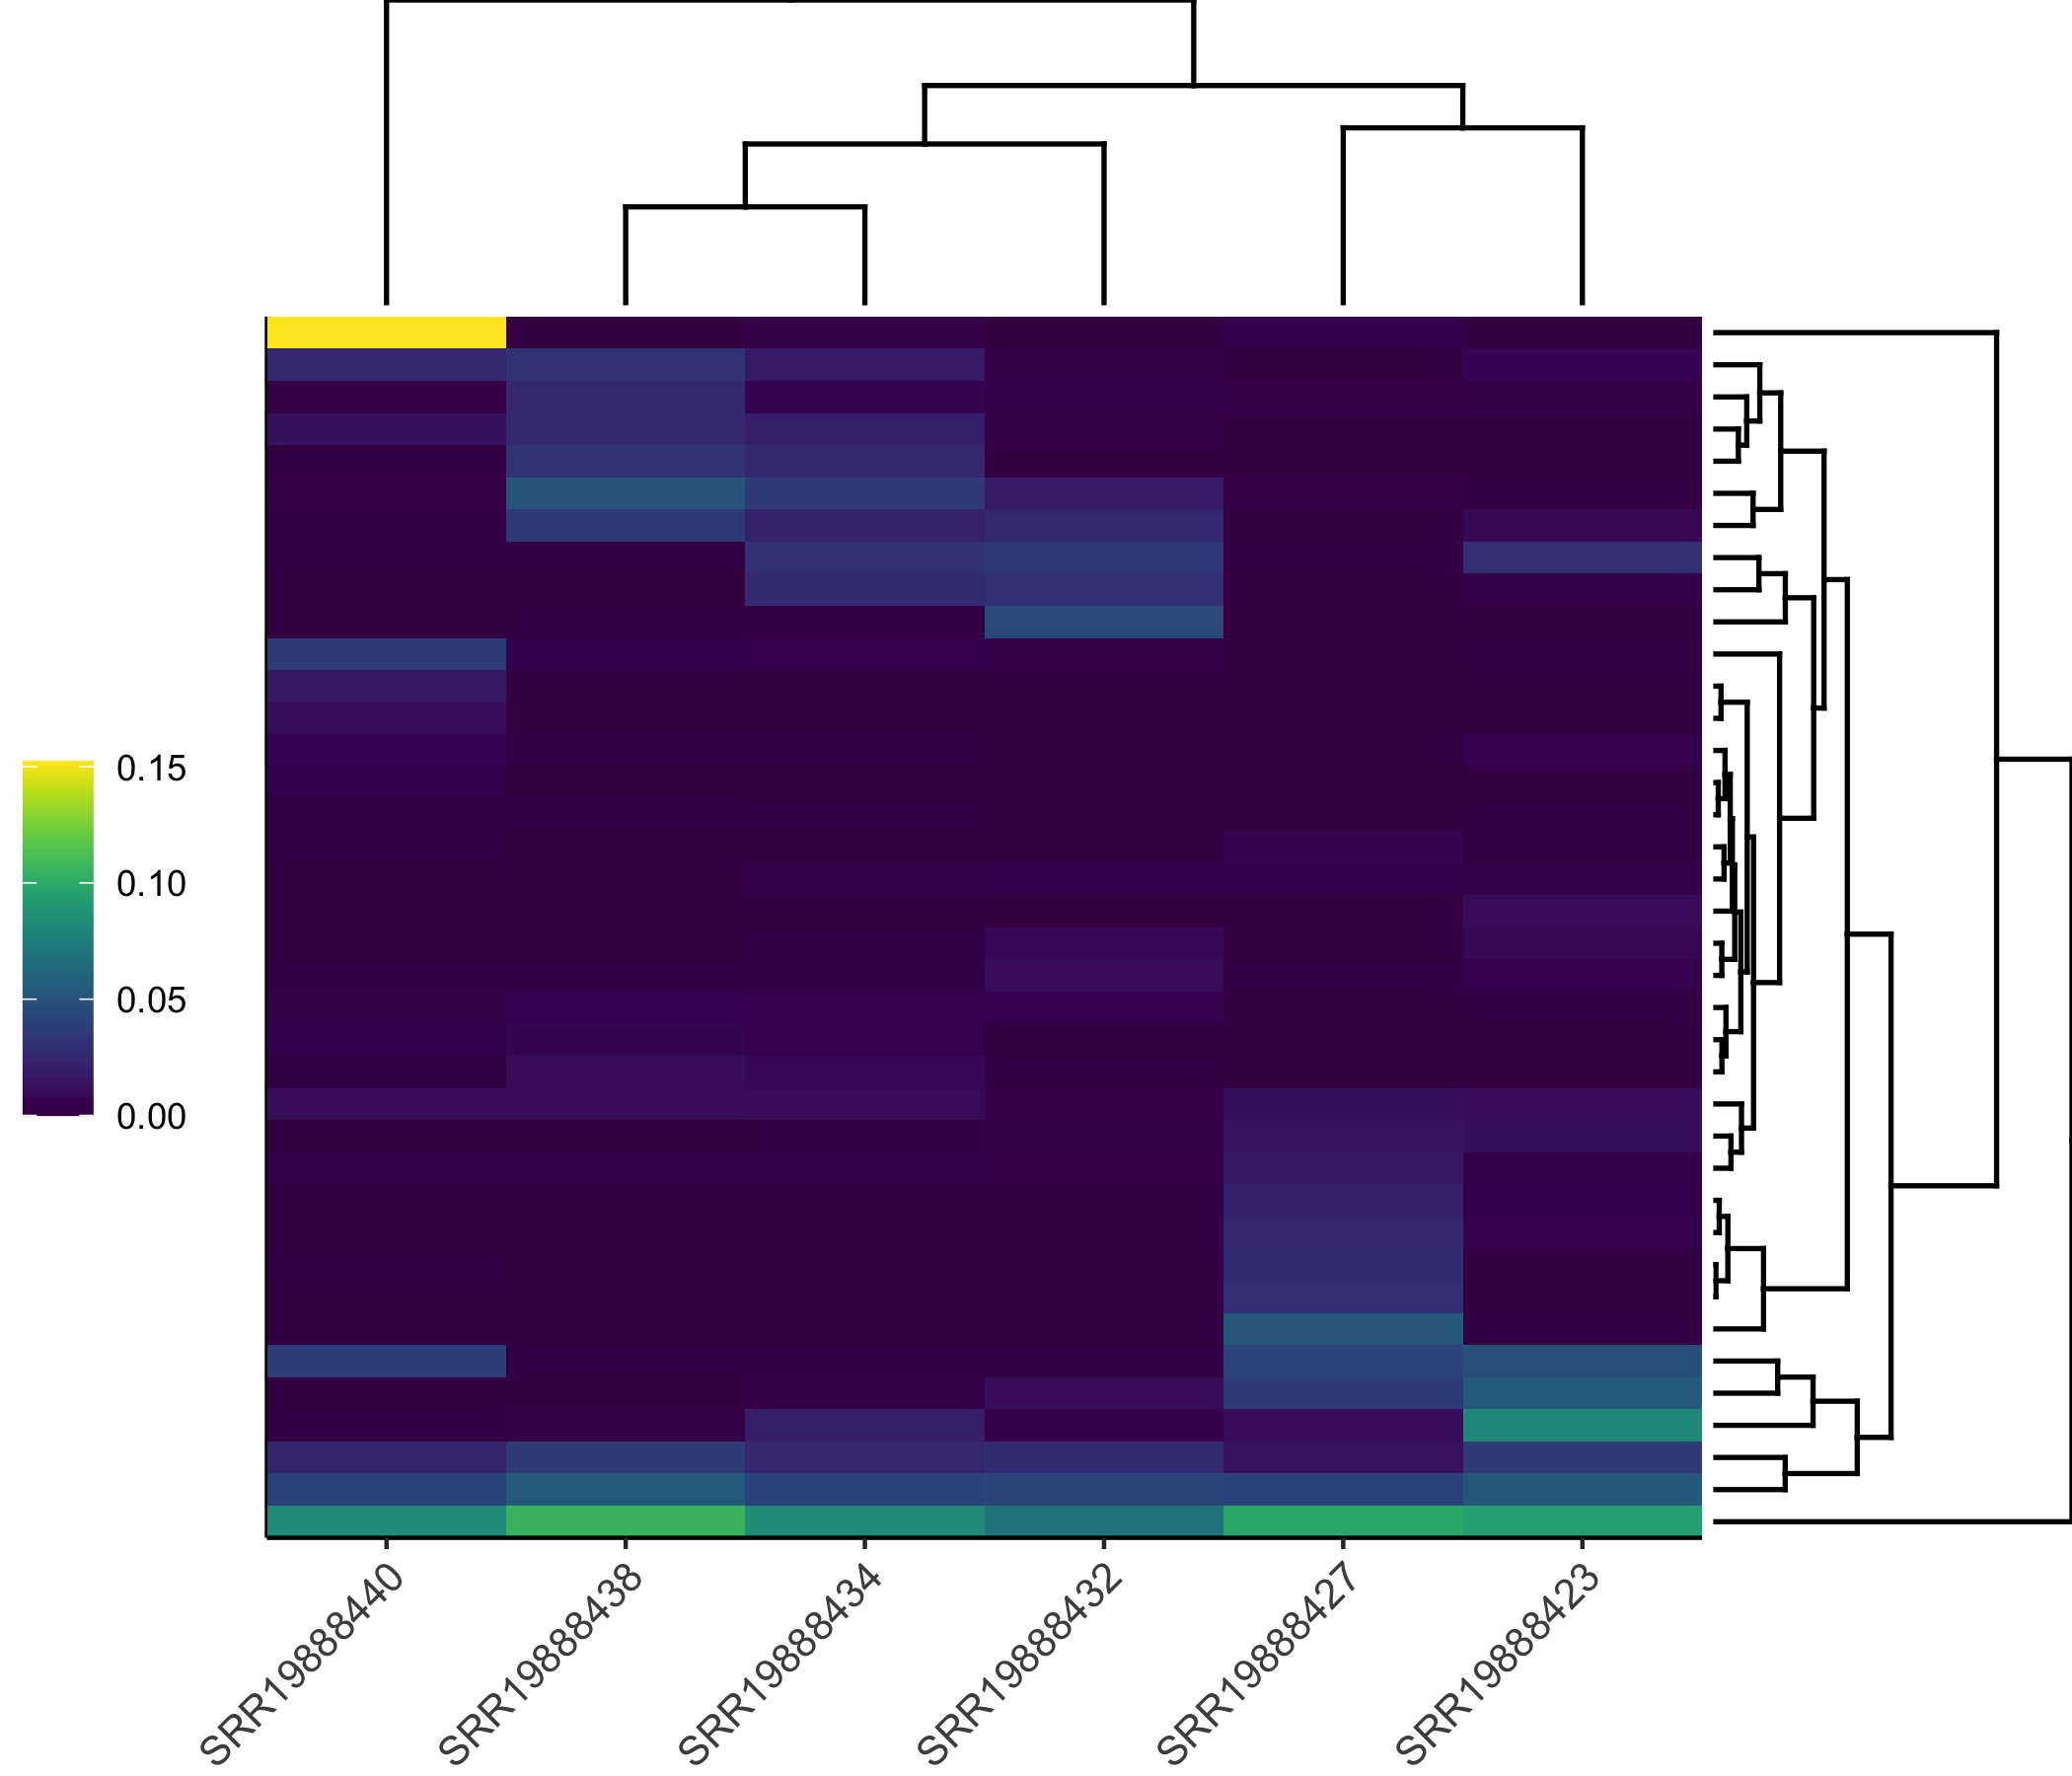

In [15]:
sourmash_taxonomy_results_wide_min_f_match <- sourmash_taxonomy_results_wide %>%
  filter(lineage %in% min_f_match$lineage) %>%
  column_to_rownames("lineage")

ggheatmap(sourmash_taxonomy_results_wide_min_f_match, showticklabels = c(T, F))

# uncomment lines to produce an interactive plot that renders inline in the notebook
# min_f_match_plt <- heatmaply(sourmash_taxonomy_results_wide_min_f_match, showticklabels = c(T, F))
# embed_notebook(min_f_match_plt, height = '800px')

### Lineages that were detected in all samples

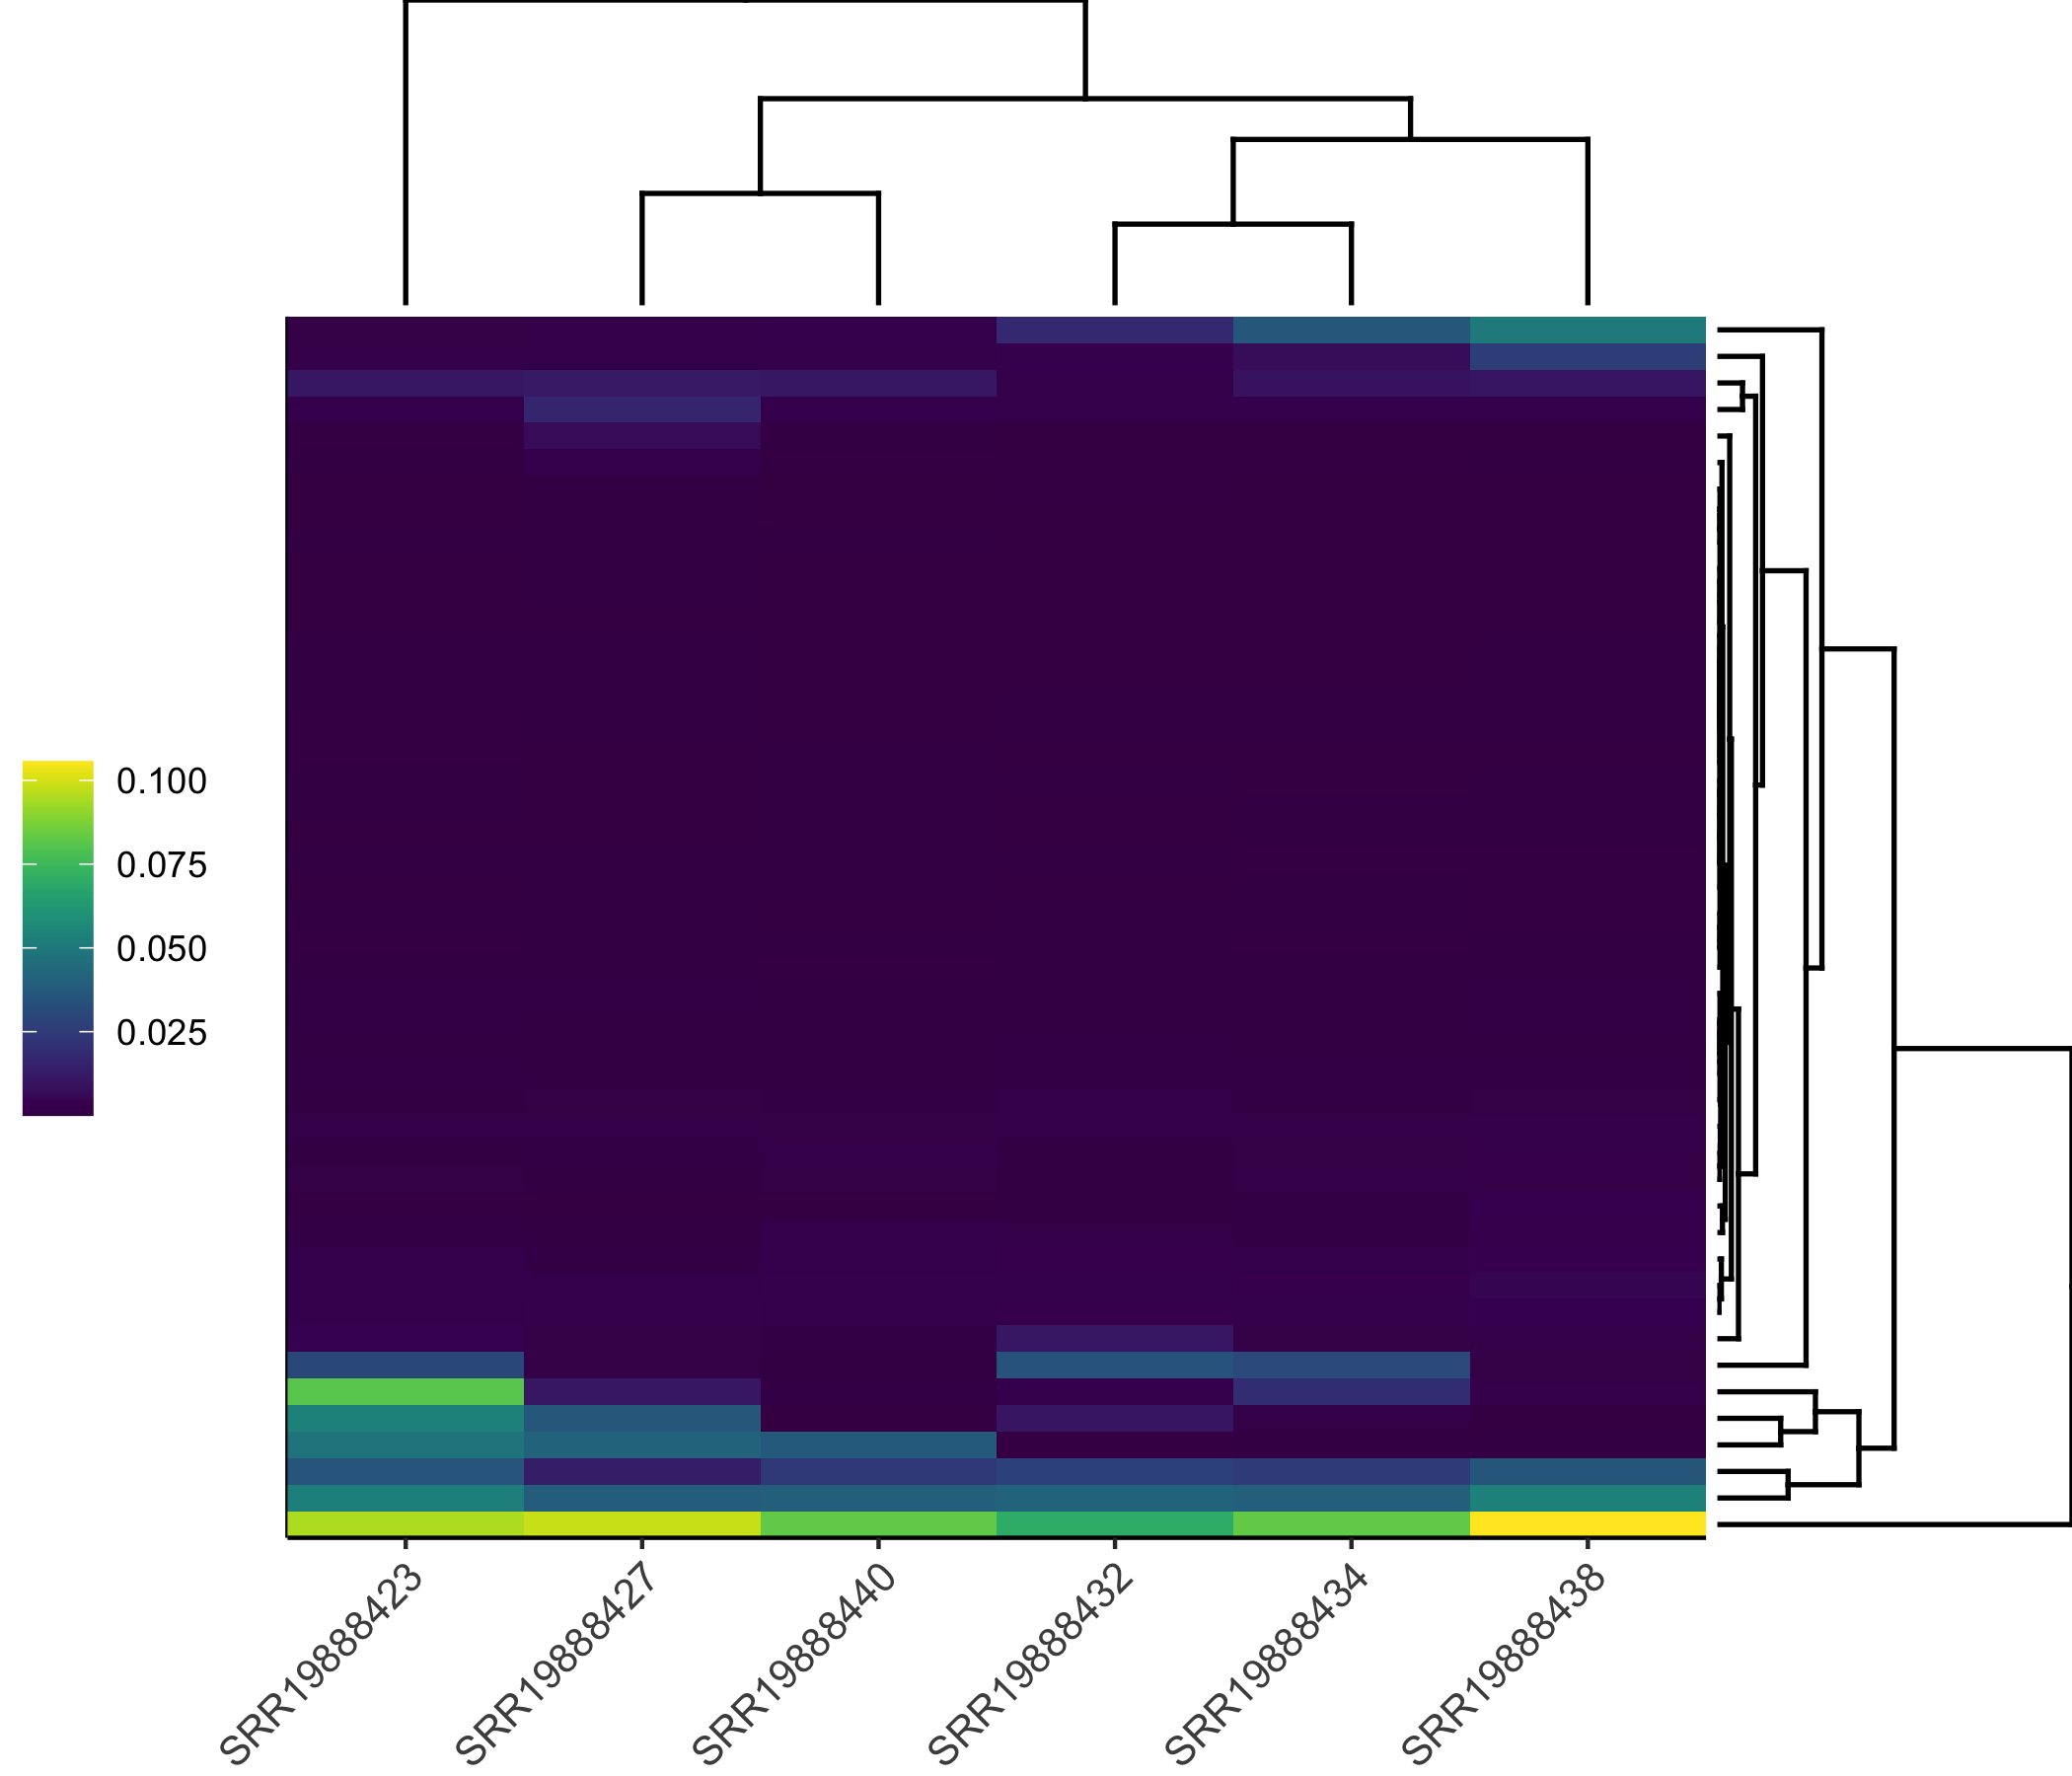

In [16]:
sourmash_taxonomy_results_wide_f_samples_detected <- sourmash_taxonomy_results_wide %>%
  filter(lineage %in% f_samples_detected$lineage) %>%
  column_to_rownames("lineage")

ggheatmap(sourmash_taxonomy_results_wide_f_samples_detected, showticklabels = c(T, F))

# uncomment lines to produce an interactive plot that renders inline in the notebook
# f_samples_detected_plt <- heatmaply(sourmash_taxonomy_results_wide_f_samples_detected, showticklabels = c(T, F))
# embed_notebook(f_samples_detected_plt, height = '1000px')

### Lineages that were present in samples greater than mean_f_unique_weighted

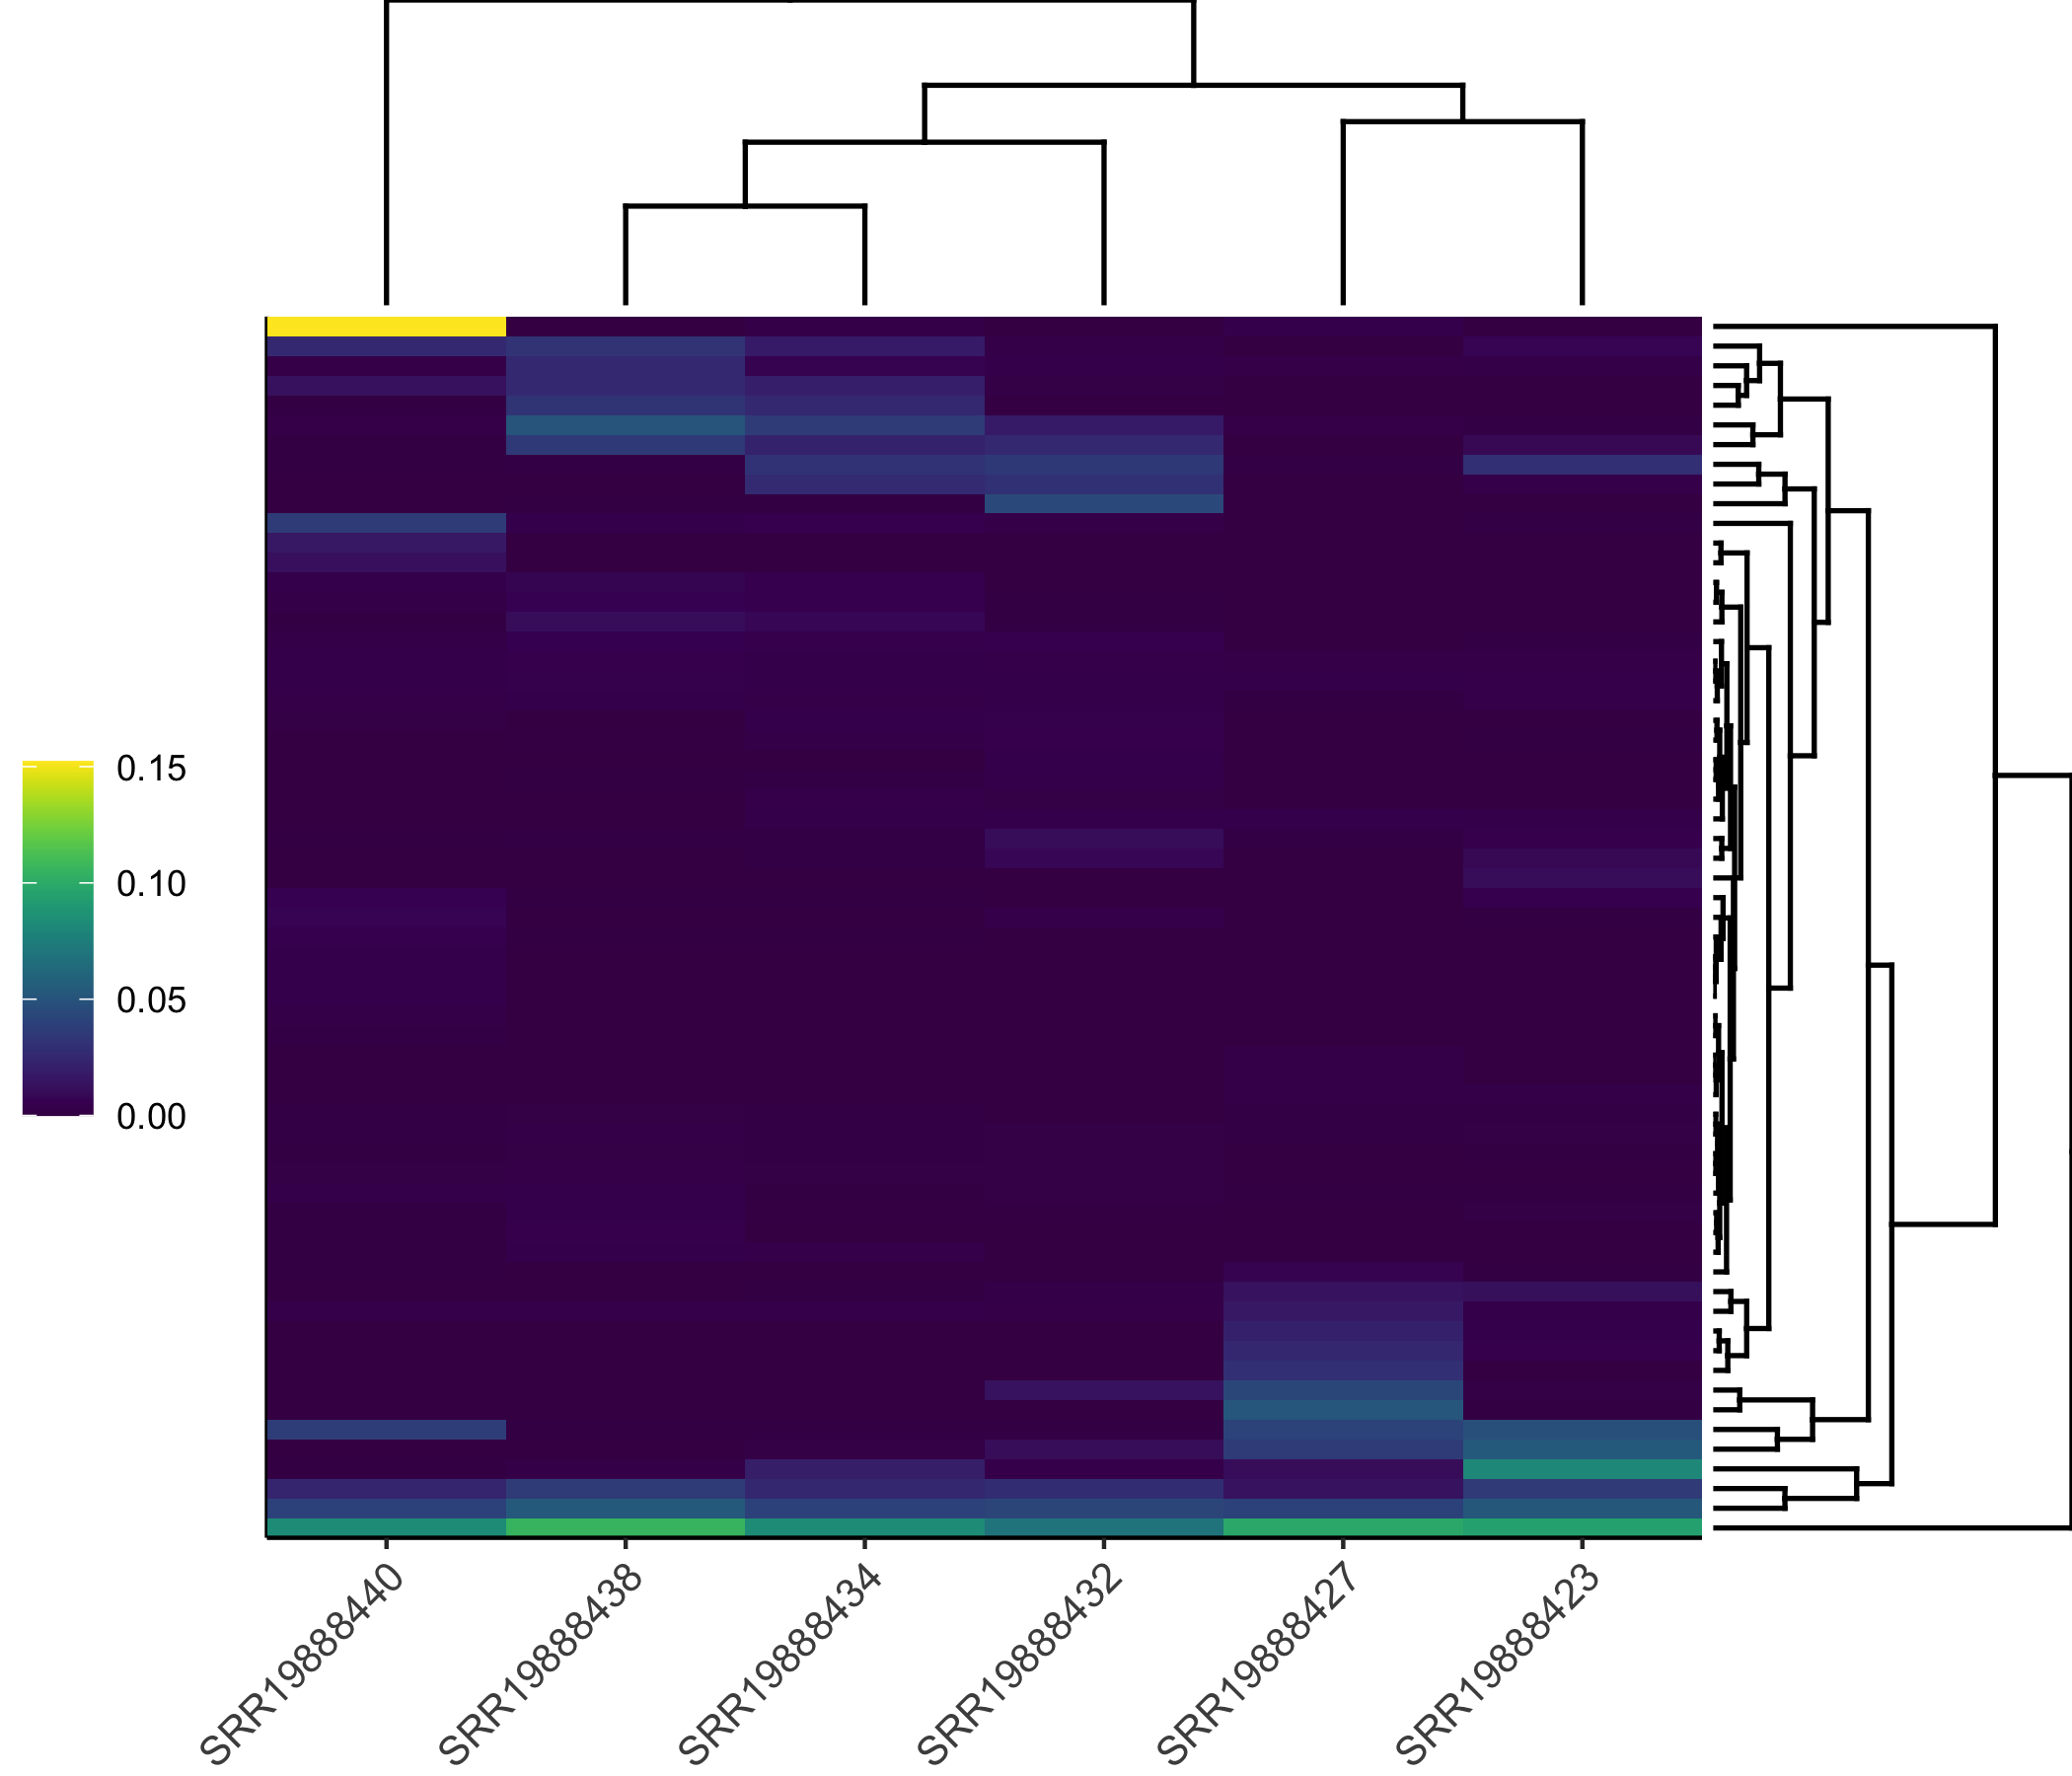

In [17]:
sourmash_taxonomy_results_wide_mean_f_unique_weighted <- sourmash_taxonomy_results_wide %>%
  filter(lineage %in% mean_f_unique_weighted$lineage) %>%
  column_to_rownames("lineage")

ggheatmap(sourmash_taxonomy_results_wide_mean_f_unique_weighted, showticklabels = c(T, F))

# uncomment lines to produce an interactive plot that renders inline in the notebook
# mean_f_unique_weighted_plt <- heatmaply(sourmash_taxonomy_results_wide_mean_f_unique_weighted, 
#                                        showticklabels = c(T, F), file = "tmp.html")
# embed_notebook(mean_f_unique_weighted_plt, height = '800px')

### Lineages that were present in a sample greater than max_f_unique_weighted

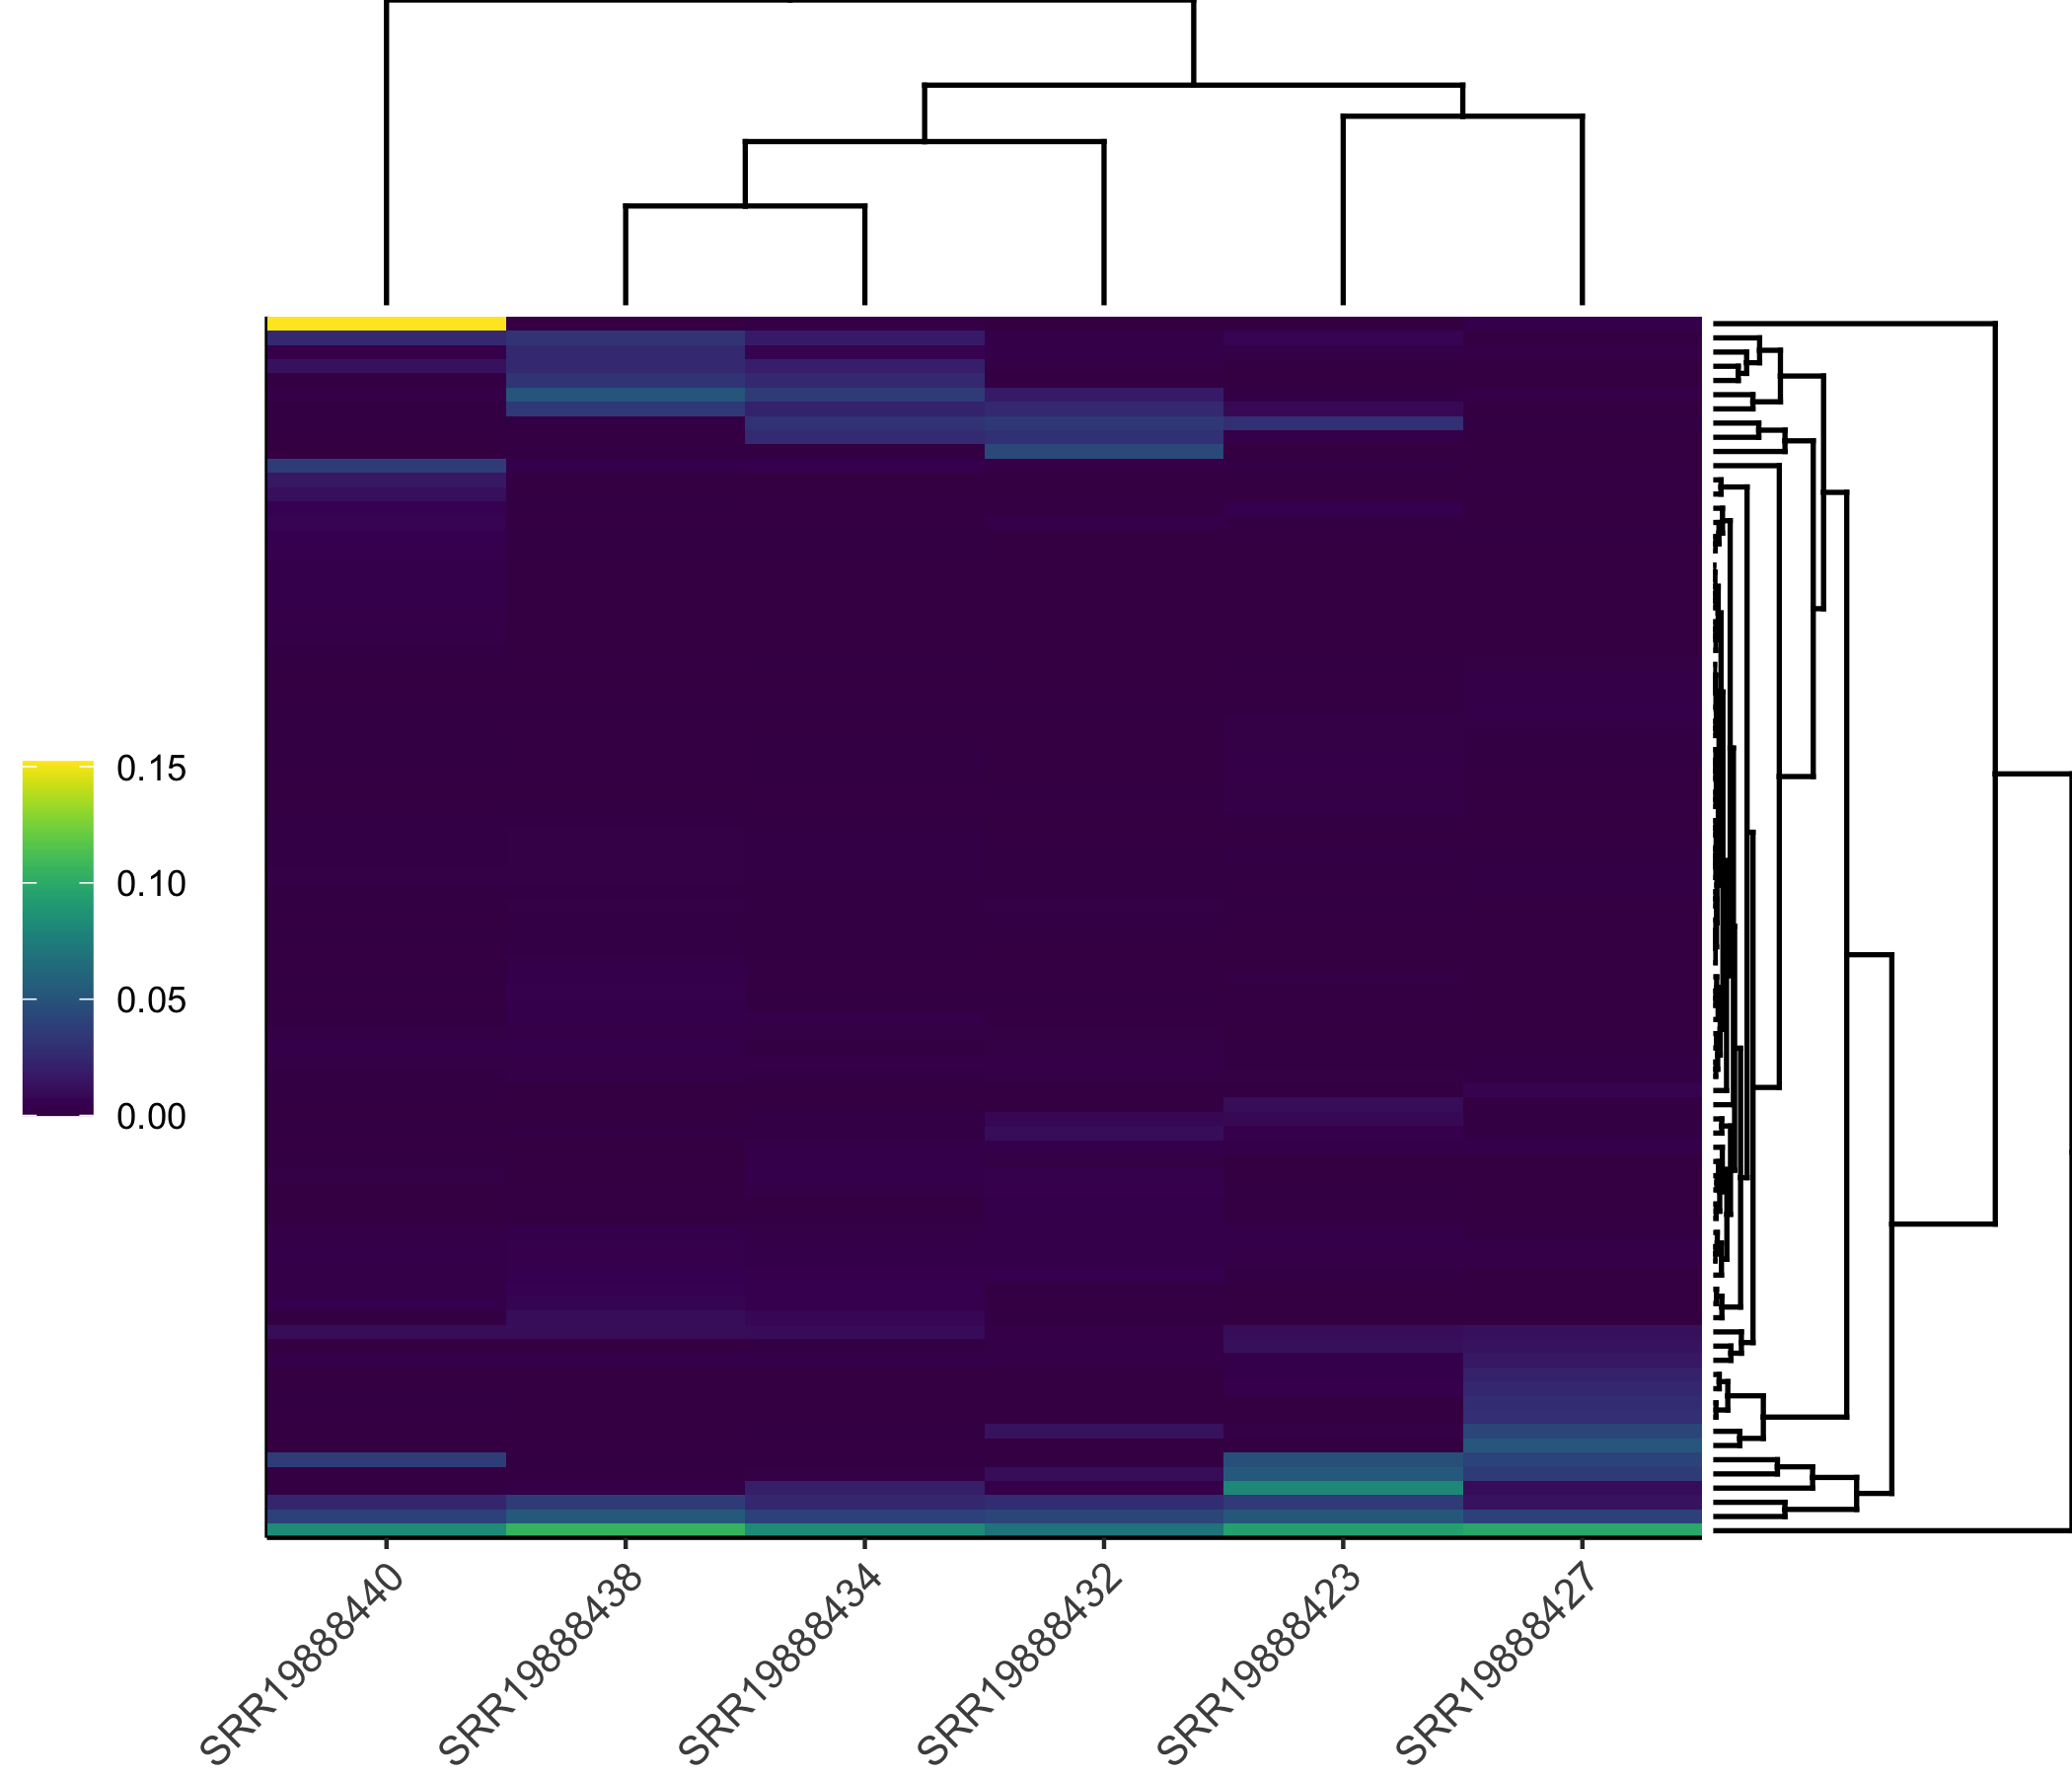

In [147]:
sourmash_taxonomy_results_wide_max_f_unique_weighted <- sourmash_taxonomy_results_wide %>%
  filter(lineage %in% max_f_unique_weighted$lineage) %>%
  column_to_rownames("lineage")

ggheatmap(sourmash_taxonomy_results_wide_max_f_unique_weighted, showticklabels = c(T, F))

# uncomment lines to produce an interactive plot that renders inline in the notebook
# max_f_unique_weighted_plt <- heatmaply(sourmash_taxonomy_results_wide_max_f_unique_weighted, showticklabels = c(T, F))
# embed_notebook(max_f_unique_weighted_plt, height = '800px')